Quality Metrics:
PSNR: 46.48 dB
NCC: 0.9676
SSIM: 0.9998


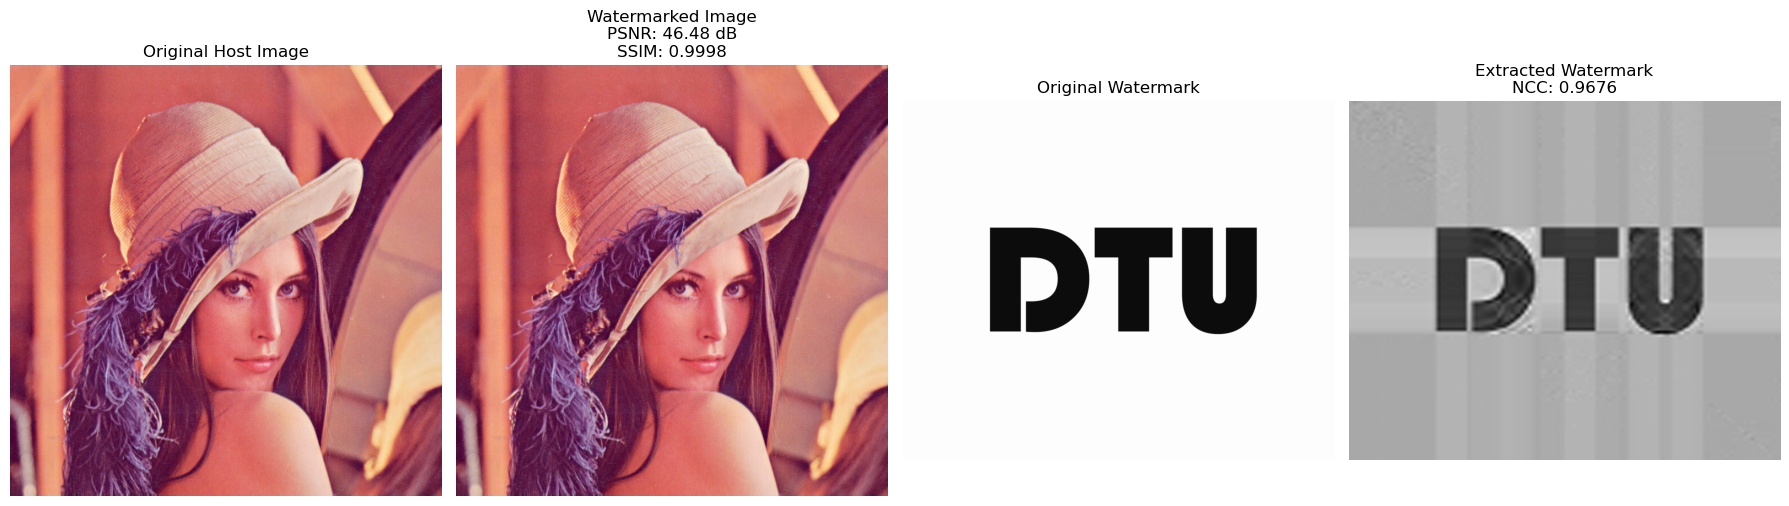

In [2]:

import cv2
import numpy as np
import pywt
import matplotlib.pyplot as plt
import os
from skimage.metrics import structural_similarity as ssim


def preprocess_images(host_path, watermark_path, dwt_level=2):
    """Load and validate images with size adjustment"""
    host = cv2.imread(host_path)
    if host is None:
        raise FileNotFoundError(f"Host image not found at {host_path}")

    watermark = cv2.imread(watermark_path, cv2.IMREAD_GRAYSCALE)
    if watermark is None:
        raise FileNotFoundError(f"Watermark image not found at {watermark_path}")

    # Adjust sizes for DWT compatibility
    divisor = 2**dwt_level
    h, w = host.shape[:2]
    host = host[:h - h % divisor, :w - w % divisor]

    return host, watermark

def embed_watermark(host, watermark, alpha=0.027):
    """DWT-SVD embedding in YCbCr color space"""
    ycbcr = cv2.cvtColor(host, cv2.COLOR_BGR2YCrCb)
    y, cb, cr = cv2.split(ycbcr)

    # 2-level DWT on Y channel
    coeffs = pywt.wavedec2(y, 'haar', level=2)
    LL = coeffs[0]

    # Resize watermark to match LL subband
    wm_resized = cv2.resize(watermark, (LL.shape[1], LL.shape[0]), interpolation=cv2.INTER_AREA)

    # SVD processing
    U_ll, S_ll, V_ll = np.linalg.svd(LL, full_matrices=False)
    U_wm, S_wm, V_wm = np.linalg.svd(wm_resized, full_matrices=False)

    # Embedding
    min_len = min(len(S_ll), len(S_wm))
    S_combined = S_ll[:min_len] + alpha * S_wm[:min_len]
    LL_modified = U_ll[:, :min_len] @ np.diag(S_combined) @ V_ll[:min_len, :]

    # Reconstruct Y channel
    coeffs = (LL_modified,) + tuple(coeffs[1:])
    y_watermarked = pywt.waverec2(coeffs, 'haar')
    y_watermarked = np.clip(y_watermarked, 0, 255).astype(np.uint8)

    # Merge channels
    watermarked_ycbcr = cv2.merge([y_watermarked, cb, cr])
    return cv2.cvtColor(watermarked_ycbcr, cv2.COLOR_YCrCb2BGR), (U_wm, V_wm, wm_resized.shape)


def extract_watermark(original, watermarked, U_wm, V_wm, original_wm_shape, alpha=0.027):
    """Watermark extraction process"""
    # Convert to YCbCr
    y_orig = cv2.cvtColor(original, cv2.COLOR_BGR2YCrCb)[:, :, 0]
    y_wm = cv2.cvtColor(watermarked, cv2.COLOR_BGR2YCrCb)[:, :, 0]

    # DWT decomposition
    coeffs_orig = pywt.wavedec2(y_orig, 'haar', level=2)
    coeffs_wm = pywt.wavedec2(y_wm, 'haar', level=2)

    # Extract singular values
    S_orig = np.linalg.svd(coeffs_orig[0], compute_uv=False)
    S_wm = np.linalg.svd(coeffs_wm[0], compute_uv=False)

    # Reconstruct watermark
    min_len = min(len(S_orig), len(S_wm))
    S_watermark = (S_wm[:min_len] - S_orig[:min_len]) / alpha

    extracted = U_wm[:, :min_len] @ np.diag(S_watermark) @ V_wm[:min_len, :]
    return cv2.resize(extracted, (original_wm_shape[1], original_wm_shape[0]), interpolation=cv2.INTER_CUBIC)

def calculate_metrics(original, watermarked, original_wm, extracted_wm):
    """Calculate PSNR, NCC, and SSIM metrics"""
    # PSNR
    mse = np.mean((original.astype(float) - watermarked.astype(float)) ** 2)
    psnr = 10 * np.log10(255**2 / mse) if mse != 0 else float('inf')

    # NCC
    ncc = np.corrcoef(original_wm.flatten(), extracted_wm.flatten())[0, 1]

    # SSIM (on luminance channel)
    y_orig = cv2.cvtColor(original, cv2.COLOR_BGR2YCrCb)[:, :, 0]
    y_wm = cv2.cvtColor(watermarked, cv2.COLOR_BGR2YCrCb)[:, :, 0]
    ssim_score, _ = ssim(y_orig, y_wm, full=True)

    return psnr, ncc, ssim_score

def display_results(original, watermarked, original_wm, extracted_wm, psnr, ncc, ssim_score):
    """Display results with matplotlib including SSIM"""
    plt.figure(figsize=(18, 6))

    # Original Host
    plt.subplot(1, 4, 1)
    plt.imshow(cv2.cvtColor(original, cv2.COLOR_BGR2RGB))
    plt.title('Original Host Image')
    plt.axis('off')

    # Watermarked
    plt.subplot(1, 4, 2)
    plt.imshow(cv2.cvtColor(watermarked, cv2.COLOR_BGR2RGB))
    plt.title(f'Watermarked Image\nPSNR: {psnr:.2f} dB\nSSIM: {ssim_score:.4f}')
    plt.axis('off')

    # Original Watermark
    plt.subplot(1, 4, 3)
    plt.imshow(original_wm, cmap='gray')
    plt.title('Original Watermark')
    plt.axis('off')

    # Extracted Watermark
    plt.subplot(1, 4, 4)
    plt.imshow(extracted_wm, cmap='gray')
    plt.title(f'Extracted Watermark\nNCC: {ncc:.4f}')
    plt.axis('off')

    plt.tight_layout()
    plt.show()

if __name__ == "__main__":
    # Path configuration
    host_path = 'lena.jpg'
    watermark_path = 'DTU.jpg'
    output_path = 'watermarked_img.jpg'

    try:
        # Step 1: Load and preprocess images
        host, watermark = preprocess_images(host_path, watermark_path)
        original_wm = watermark.copy()

        # Step 2: Embed watermark
        watermarked, (U_wm, V_wm, wm_shape) = embed_watermark(host, watermark)
        cv2.imwrite(output_path, watermarked)

        # Step 3: Extract watermark
        extracted_wm = extract_watermark(host, watermarked, U_wm, V_wm, watermark.shape)

        # Step 4: Calculate metrics
        psnr, ncc, ssim_score = calculate_metrics(host, watermarked, original_wm, extracted_wm)

        # Step 5: Display results
        print(f"Quality Metrics:\nPSNR: {psnr:.2f} dB\nNCC: {ncc:.4f}\nSSIM: {ssim_score:.4f}")
        display_results(host, watermarked, original_wm, extracted_wm, psnr, ncc, ssim_score)

    except Exception as e:
        print(f"Error: {str(e)}")
        if 'host' in locals():
            print(f"Host image size: {host.shape}")
        if 'watermark' in locals():
            print(f"Watermark size: {watermark.shape}")



Enter the path of the watermarked image:watermarked_img.jpg

Results Table:
Attack                         PSNR (dB)  NCC        SSIM      
------------------------------------------------------------
Rotated 0.1°                   39.17      0.9971     0.9738    
Rotated 0.2°                   35.56      0.9892     0.9186    
Scaled 1.002x                  37.99      0.9973     0.9616    
Scaled 1.003x                  37.99      0.9973     0.9616    
Cropped 0.2%                   34.61      0.9903     0.8957    
Cropped 0.1%                   34.39      0.9874     0.8917    
Translated (Tx=0.1, Ty=0.1)    43.82      0.9994     0.9944    
Sheared 0.0005x                42.64      0.9992     0.9940    
Gaussian Noise (σ=2)           44.71      0.9996     0.9832    
Gaussian Noise (σ=4)           39.35      0.9984     0.9412    
Salt & Pepper (0.01)           44.81      0.9260     0.5996    
Salt & Pepper (0.02)           41.83      0.8626     0.3967    
Speckle Noise (var=0.01)       

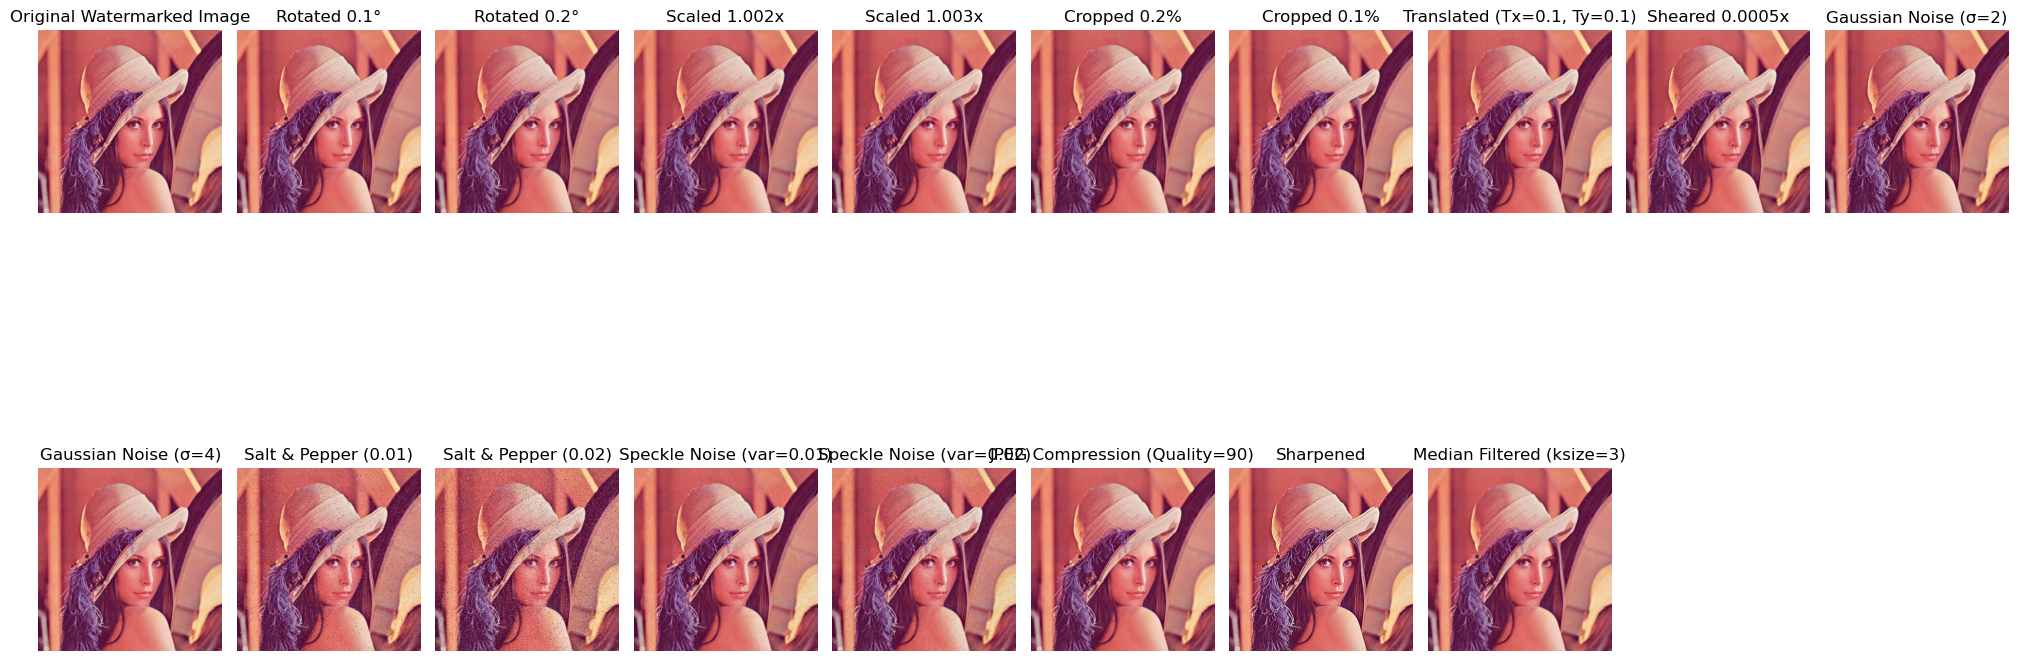

In [3]:
import cv2
import numpy as np
import math
import matplotlib.pyplot as plt
from skimage.metrics import structural_similarity as ssim

# PSNR Calculation Function
def calculate_psnr(original, attacked):
    mse = np.mean((original - attacked) ** 2)
    if mse == 0:
        return float('inf')
    return 20 * math.log10(255.0 / math.sqrt(mse))

# NCC Calculation Function
def calculate_ncc(original, attacked):
    original_flattened = original.flatten().astype(np.float32)
    attacked_flattened = attacked.flatten().astype(np.float32)
    numerator = np.sum((original_flattened - np.mean(original_flattened)) *
                       (attacked_flattened - np.mean(attacked_flattened)))
    denominator = np.sqrt(np.sum((original_flattened - np.mean(original_flattened)) ** 2) *
                          np.sum((attacked_flattened - np.mean(attacked_flattened)) ** 2))
    return numerator / denominator if denominator != 0 else 1

# SSIM Calculation Function
def calculate_ssim(original, attacked):
    return ssim(original, attacked, data_range=attacked.max() - attacked.min())

# Load watermarked image
watermarked_img_path = input("Enter the path of the watermarked image:")
watermarked_image = cv2.imread(watermarked_img_path, cv2.IMREAD_COLOR)
if watermarked_image is None:
    raise ValueError("Error: Watermarked image not found or failed to load.")

# Convert to RGB (for visualization)
watermarked_image = cv2.cvtColor(watermarked_image, cv2.COLOR_BGR2RGB)

# Convert to grayscale for metric calculations
watermarked_gray = cv2.cvtColor(watermarked_image, cv2.COLOR_RGB2GRAY)

# Geometric Attack Functions
def rotate_image(image, angle):
    center = (image.shape[1] // 2, image.shape[0] // 2)
    matrix = cv2.getRotationMatrix2D(center, angle, 1.0)
    return cv2.warpAffine(image, matrix, (image.shape[1], image.shape[0]))

def scale_image(image, scale_factor):
    new_w = int(image.shape[1] * scale_factor)
    new_h = int(image.shape[0] * scale_factor)
    return cv2.resize(image, (new_w, new_h), interpolation=cv2.INTER_LINEAR)

def translate_image(image, x_shift, y_shift):
    matrix = np.float32([[1, 0, x_shift], [0, 1, y_shift]])
    return cv2.warpAffine(image, matrix, (image.shape[1], image.shape[0]))

def crop_image(image, crop_factor):
    h, w = image.shape[:2]
    new_h = int(h * (1 - crop_factor))
    new_w = int(w * (1 - crop_factor))

    if new_h <= 0 or new_w <= 0:
        print(f"Skipping crop {crop_factor * 100:.0f}% - results in an empty image.")
        return None

    start_h = (h - new_h) // 2
    start_w = (w - new_w) // 2
    return image[start_h:start_h + new_h, start_w:start_w + new_w]

def shear_image(image, shear_factor):
    h, w = image.shape[:2]
    matrix = np.float32([[1, shear_factor, 0], [0, 1, 0]])
    return cv2.warpAffine(image, matrix, (w + int(h * shear_factor), h))

# Noise Attack Functions
def add_gaussian_noise(image, mean=0, sigma=10):
    """Add Gaussian noise to the image"""
    row, col, ch = image.shape
    gauss = np.random.normal(mean, sigma, (row, col, ch))
    noisy = np.clip(image.astype(np.float32) + gauss, 0, 255).astype(np.uint8)
    return noisy

def add_salt_pepper_noise(image, salt_prob=0.02, pepper_prob=0.02):
    """Add salt and pepper noise to the image"""
    noisy = np.copy(image)
    # Salt noise (white spots)
    salt_mask = np.random.random(image.shape[:2]) < salt_prob
    noisy[salt_mask] = 255

    # Pepper noise (black spots)
    pepper_mask = np.random.random(image.shape[:2]) < pepper_prob
    noisy[pepper_mask] = 0

    return noisy

# New Attack Functions
def add_speckle_noise(image, var=0.1):
    """Add speckle noise to the image with controlled variance"""
    row, col, ch = image.shape
    gauss = np.random.normal(0, np.sqrt(var), (row, col, ch))
    noisy = image.astype(np.float32) + image.astype(np.float32) * gauss
    noisy = np.clip(noisy, 0, 255).astype(np.uint8)
    return noisy


def jpeg_compression(image, quality=90):
    """Apply JPEG compression to the image"""
    encode_param = [int(cv2.IMWRITE_JPEG_QUALITY), quality]
    result, encimg = cv2.imencode('.jpg', cv2.cvtColor(image, cv2.COLOR_RGB2BGR), encode_param)
    if result:
        decimg = cv2.imdecode(encimg, cv2.IMREAD_COLOR)
        return cv2.cvtColor(decimg, cv2.COLOR_BGR2RGB)
    else:
        return image



def sharpen_image(image):
    """Apply sharpening to the image"""
    kernel = np.array([[0, -1, 0],
                       [-1, 5, -1],
                       [0, -1, 0]])
    sharpened = cv2.filter2D(image, -1, kernel)
    return sharpened

def median_filter(image, ksize=3):
    """Apply median filtering to the image"""
    return cv2.medianBlur(image, ksize)

# Apply attacks
attacks = {
    "Rotated 0.1°": rotate_image(watermarked_image, 0.1),
    "Rotated 0.2°": rotate_image(watermarked_image, 0.2),
    "Scaled 1.002x": scale_image(watermarked_image, 1.002),
    "Scaled 1.003x": scale_image(watermarked_image, 1.003),
    "Cropped 0.2%": crop_image(watermarked_image, 0.002),
    "Cropped 0.1%": crop_image(watermarked_image, 0.001),
    "Translated (Tx=0.1, Ty=0.1)": translate_image(watermarked_image, 0.1, 0.1),
    "Sheared 0.0005x": shear_image(watermarked_image, 0.0005),
    "Gaussian Noise (σ=2)": add_gaussian_noise(watermarked_image, 0, 2),
    "Gaussian Noise (σ=4)": add_gaussian_noise(watermarked_image, 0, 4),
    "Salt & Pepper (0.01)": add_salt_pepper_noise(watermarked_image, 0.01, 0.01),
    "Salt & Pepper (0.02)": add_salt_pepper_noise(watermarked_image, 0.02, 0.02),
    # New attacks
    "Speckle Noise (var=0.01)": add_speckle_noise(watermarked_image, 0.01),
    "Speckle Noise (var=0.02)": add_speckle_noise(watermarked_image, 0.02),
    "JPEG Compression (Quality=90)": jpeg_compression(watermarked_image, 90),

    "Sharpened": sharpen_image(watermarked_image),
    "Median Filtered (ksize=3)": median_filter(watermarked_image, 3),
}

# Calculate PSNR, NCC, and SSIM
results = []
for attack_name, attacked_image in attacks.items():
    if attacked_image is None or attacked_image.size == 0:
        print(f"Skipping {attack_name} due to empty output.")
        continue

    # Resize attacked image to match original dimensions
    attacked_resized = cv2.resize(attacked_image, (watermarked_image.shape[1], watermarked_image.shape[0]))

    # Convert to grayscale for metric calculations
    attacked_gray = cv2.cvtColor(attacked_resized, cv2.COLOR_RGB2GRAY)

    # Compute metrics
    psnr = calculate_psnr(watermarked_gray, attacked_gray)
    ncc = calculate_ncc(watermarked_gray, attacked_gray)
    ssim_value = calculate_ssim(watermarked_gray, attacked_gray)

    results.append((attack_name, psnr, ncc, ssim_value))

# Print Results Table
print("\nResults Table:")
print("{:<30} {:<10} {:<10} {:<10}".format("Attack", "PSNR (dB)", "NCC", "SSIM"))
print("-" * 60)
for attack_name, psnr, ncc, ssim_value in results:
    print("{:<30} {:<10.2f} {:<10.4f} {:<10.4f}".format(attack_name, psnr, ncc, ssim_value))

# Visualization of Images
plt.figure(figsize=(20, 10))
plt.subplot(2, len(results)//2 + 2, 1)
plt.title("Original Watermarked Image")
plt.imshow(watermarked_image)
plt.axis("off")

for i, (attack_name, _, _, _) in enumerate(results, 2):
    attacked_image = attacks[attack_name]
    attacked_resized = cv2.resize(attacked_image, (watermarked_image.shape[1], watermarked_image.shape[0]))
    plt.subplot(2, len(results)//2 + 2, i)
    plt.title(f"{attack_name}")
    plt.imshow(attacked_resized)
    plt.axis("off")

plt.tight_layout()
plt.show()
